# Dynamics: simulation and control
This notebook focuses on the robot dynamics, for both simulating the behavior of the robot when forces are applied to it, and computing dynamic-aware control laws like computed torque.


In [1]:
import magic_donotload
%config Completer.use_jedi = False

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide the solutions to some questions. Change it for %load if you want to see (and execute) the solution.


## Set up 
We will use Pinocchio, the viewer and the QP solver quadprog. We use an ad-hoc model of a robot hand with simple geometry to make the contact simulation problem simple. 


In [2]:
import math
import time
import pinocchio as pin
import numpy as np
from numpy.random import rand
from numpy.linalg import inv,pinv,norm,eig,svd
import matplotlib.pylab as plt; plt.ion()
import quadprog
from tp6.robot_hand import RobotHand
from tp6.meshcat_viewer_wrapper import MeshcatVisualizer

## QuadProg solver
QuadProg is a simple QP solver that is very convenient to import in Python and very simple to use. 

It is package in robotpkg apt repository (alternatively in pip), install it with 
"sudo apt install robotpkg-py35-quadprog" or alternatively "pip install --user quadprog".

A simple example using QuadProg is as follow. First randomly define a QP problem min 1/2 x'Ax - b'x s.t. Cx>=0

$$\min_x \frac{1}{2} x^T A x - b^T x$$
Under the constraints:
$$C x \ge d$$

In [67]:
# %load -r 10-16 tp4/qp.py
A = np.random.rand(5,5)*2-1
A = A @ A.T ### Make it positive symmetric
b = np.random.rand(5)

C = np.random.rand(10,5)
d = np.random.rand(10)


The quadratic program can be solved by calling:

In [4]:
# %load -r 19 tp4/qp.py
[x,cost,_,niter,lag,iact] = quadprog.solve_qp(A,b,C.T,d)  # Notice that C.T is passed instead of C

where x is the solution, cost is the value of the cost function at x, niter is the number of iterations needed to obtain the optimum, lag is the dual optimum (lagrange multipliers) and iact are the active constraints (numbered from 1 to N, i.e. lag[iact-1] is not null). See the doc for more details.

In [ ]:
# help(quadprog.solve_qp)

## A robot hand for our test

For this notebook, we need the additional package Fast-Collision-Library "sudo apt install robotpkg-py36-hpp-fcl".

We are going to use a 4-finger hand, whose model is defined in Python (no urdf model) using capsule volumes.
The hand is defined in the python code robot_hand.py. You can load and 
display it like this (don't forget to turn gepetto-viewer on with starting gepetto-gui).

In [3]:
robot=RobotHand()
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Take care that the hand is small: zoom in to see it in the window.

In [8]:
q0 = robot.q0.copy()
from ipywidgets import interact
@interact(q=(0., 2., 0.1))
def move_fingers1(q=0.3):
    q0[1:11] = q
    viz.display(q0)
@interact(q=(-.5, 1.8, 0.01))
def move_thumb(q=0.7):
    q0[11:] = q
    viz.display(q0)

interactive(children=(FloatSlider(value=0.3, description='q', max=2.0), Output()), _dom_classes=('widget-inter…

interactive(children=(FloatSlider(value=0.7, description='q', max=1.8, min=-0.5, step=0.01), Output()), _dom_c…

Remember that the model rendered in the viewer is just a display, not a simulation (yet).  You can pretty much achieve any movements you want in this display, because we are not enforcing (yet) any physical law. For example, if you want to move the fingers following any trajectories you like, you can do:

In [7]:
q = robot.q0.copy()

for i in range(500): # Put 1000 or 5000 if you want a longer move.
    for iq in range(3,robot.model.nq):
        q[iq] = -1+np.cos(i*1e-2*(1+iq/5))
    viz.display(q)
    time.sleep(2e-3)


## Forward unconstrained dynamics
### Computing the acceleration

In a first time, let's play with the dynamics without constraints (hence without quadprog).

Choosing an arbitrary joint torque $\tau_q$, pinocchio can compute the robot acceleration and integrate it.

The dynamic equation of the robot is $M a_q + b = \tau_q$, with $M$ the mass, $a_q$ the joint acceleration and $b$ the drift.
The mass matrix can be computed using *CRB* algorithm (function of q). The drift is computed using *RNE* algorithm (function of $q$, $v_q$ and $a_q$ with $a_q=0$). 


In [15]:
q   = rand(robot.model.nq)
vq  = rand(robot.model.nv)
aq0 = np.zeros(robot.model.nv)
b = pin.rnea(robot.model,robot.data,q,vq,aq0)  # compute dynamic drift -- Coriolis, centrifugal, gravity
M = pin.crba(robot.model,robot.data,q)         # compute mass matrix M
print (norm(M-M.T))
print(len(M))


0.0
14


These terms correspond to the inverse dynamics. They can be numerically inverted to compute the direct dynamics.

In [ ]:
tauq = np.zeros(robot.model.nv)

Using $M$ and $b$ computed by the above algorithms, and knowing a given set of joint torques $\tau_q$, how would you compute $a_q$ so that $M a_q + b = \tau_q$?

In [ ]:
# %load -r 32 tp6/solution_pd.py
aq = inv(M) @ (tauq - b)

The inverse-dynamics algorithm indeed compute the needed torques to achieve a given acceleration. We can use this function to double-check our result:

In [ ]:
print(norm(pin.rnea(robot.model,robot.data,q,vq,aq)-tauq))

### Integrating the acceleration

Once aq as been computed, it is straight forward to integrate it to velocity using $v_q += a_q \Delta t$. 
Integration to joint position is more complex in general, as we saw for the mobile robot. Here, $n_q = n_v$ and everything is Euclinea, so a simple += integration would work, but since it is implemented in pinocchio, let's keep the good habits:

In [ ]:
dt = 5e-3
vq += aq*dt
q = pin.integrate(robot.model,q,vq*dt)

Now, you should be able to implement a first simulation (not a rendering any more) of the robot behavior when no torque is applied (tauq = 0).



In [ ]:
tauq = np.zeros(robot.model.nv)

In [ ]:
%do_not_load -r 32-35 tp6/solution_pd.py
b = pin.rnea(robot.model,robot.data,q,vq,aq0)
aq = inv(M) @ (tauq - b)
vq += aq*dt
q = pin.integrate(robot.model,q,vq*dt)

Now modify the simulator to encompass joint friction, i.e. the torque is opposite to the velocity with a friction coefficient $K_f$ (take $K_f=0.1$ as a start).

In [ ]:
q = robot.q0.copy()
Kf = 0.1
for it in range(2000):
    t = it*dt
    ### Compute acceleration instead of this comment
    M = pin.crba(robot.model,robot.data,q)
    b = pin.rnea(robot.model,robot.data,q,vq,np.zeros(robot.model.nv))
    tauq = -Kf*vq
    aq = inv(M) @ (tauq - b)
    ### Integrate the acceleration twice instead of this comment
    vq += aq*dt
    q = pin.integrate(robot.model,q,vq*dt)
    if it%20==0: 
        viz.display(q)
        time.sleep(20*dt)
    

## (optional) Reference trajectory
If you like it, a class is implemented to compute a reference trajectory as a sinus with various frequency, phase and amplitude on each joint. It is implemented in traj_ref with the class TrajRef.

In [6]:
from tp6.traj_ref import TrajRef

In this simple example, we define a trajectory in dimension 3, starting at t=0 from q=[0,0,0], with 3 sinusoid of frequency 1,2 and 3, all with the same amplitude 1.5.

In [ ]:
# %load -r 30- tp6/traj_ref.py
qdes = TrajRef(np.array([0,0,0.]),omega = np.array([1,2,3.]),amplitude=1.5)
t = 0.2
print(qdes(t),qdes.velocity(t),qdes.acceleration(t))


## Proportional-derivative and computed torque

Now choose a reference joint position (possibly time varying, like in the hand example).
The joint torques can then be computed to track the desired position, with $\tau_q = -K_p (q-q^{des}) - K_v v_q$. Both gains $K_p$ and $K_v$ should be properly chosen. Optimal tracking is obtained with $K_v = 2 \sqrt{K_p}$. 
In general, a desired velocity is also tracked to avoid tracking errors.



In [31]:
%do_not_load -r 12- tp6/solution_pd.py
qdes = TrajRef(robot.q0,omega = np.array([0,.1,1,1.5,2.5,-1,-1.5,-2.5,.1,.2,.3,.4,.5,.6]),amplitude=1.5)

q = robot.q0.copy()
vq = np.zeros(robot.model.nv)
dt = 1e-3
Kp = 50
Kv = 2 * np.sqrt(Kp)
hq = []
hqdes = []
for it in range(10000):
    t = it*dt
    ### Compute acceleration instead of this comment
    M = pin.crba(robot.model,robot.data,q)
    b = pin.rnea(robot.model,robot.data,q,vq,np.zeros(robot.model.nv))
    tauq = -Kp*(q - qdes(t)) - Kv*(vq-qdes.velocity(t))
    aq = inv(M) @ (tauq - b)
    ### Integrate the acceleration twice instead of this comment
    vq += aq*dt
    q = pin.integrate(robot.model,q,vq*dt)
    hq.append(q.copy())
    hqdes.append(qdes(t).copy())
    if it%20==0: 
        viz.display(q)
        time.sleep(20*dt)


KeyboardInterrupt: 

Here, there is a strong coupling between joints, due to the mass matrix that is not compensated in the simple PD law. In theory, the computed torques is to compute the joint torque by inverse dynamics from a reference joint acceleration. This boils down to canceling the simulation equation by choosing the proper terms in the control law. It is now very interesting to implement in case of perfect dynamics knowledge. It might be more interesting to study in case the simulation is done with the perfect M, while the control is computed with approximate M (for example, using only the diagonal terms of the mass matrix). Let's rather simulate contact.


It is intersting to plot the results. In the solution of the previous example, the effective and desired position q and qdes have been stored in a log list. We can display them with matplotlib.

In [ ]:
plt.subplot(211)
plt.plot([q[2] for q in hq])
plt.plot([q[2] for q in hqdes])
plt.ylabel('Joint #2')
plt.subplot(212)
plt.plot([q[3] for q in hq])
plt.plot([q[3] for q in hqdes]);
plt.ylabel('Joint #1')
plt.xlabel('Iterations')

## Collision checking

Pinocchio is built on top of HPP FCL (a fork of the Free-Collision-Lib) to compute collision and distances. For this notebook, a wrapper as been set up to make the computation easier.


In [9]:
from tp6.collision_wrapper import CollisionWrapper
print(q0)
colwrap = CollisionWrapper(robot)
colwrap.computeCollisions(q0)
collisions = colwrap.getCollisionList()
print(collisions)
print(collisions[0])
for i in robot.model.names:
    print(i)
g1 = colwrap.gmodel.geometryObjects[collisions[0][1].first].parentJoint
print(g1)

[0.  0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.7 0.7 0.7]
[]


IndexError: list index out of range

getCollisionList returns a list of all the active collisions. The list containts triplets i,c,r, with i the index of the collision pair, c the collition pair and r a structure containg the collision details, in particular the collision position in world frame and the collision normal. 

From this list, it is possible to compute various quantities, in particular the contact Jacobian (corresponding to the normal direct of each contact), the contact distances (positive or negative when using capsules, negative distances might not be properly defined when using more complex geometries), and the self-acceleration of the contact point (similar to Coriolis acceleration, i.e. due to the velocity of the joints, also denoted by Jdot*qdot)

In [46]:
#dist=colwrap.getCollisionDistances(collisions)
#print(dist)
#J = colwrap.getCollisionJacobian(collisions)
#print(J)

#isCollision = []
#for i in range(len(dist)):
#    if (abs(dist[i]) < 5e-3):
#        print(i)
#        isCollision.append(collisions[i])
#dist = colwrap.getCollisionDistances(isCollision)
#print(dist)

vq = q0.copy()
print(vq)
#vq = vq - pinv(J)@J@vq
#print(vq)
colwrap.computeCollisions(q0,vq)
collisions = colwrap.getCollisionList()
print(colwrap.getCollisionJdotQdot(collisions))

[0.   1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  0.11 0.11 0.11]
[[-0.15874812]]


Better try this with a configuration of the hand where there are some collisions.

## Contact simulator

### 1. Enforce positive acceleration 

The joint acceleration is constrained by the contact constraint. It can be written as a minimization problem using Gauss principle
$$min \quad \frac{1}{2}  (\ddot{q} - \ddot{q}_0 )^T M (\ddot{q} - \ddot{q}_0 )$$
$$s.t. \quad J \ddot{q} >= 0 $$
where $ \ddot{q}_0 = M^{-1} (\tau-b)$ is the free acceleration, i.e. the acceleration obtained in Question 2 where no constraint is active.


### 2. Impact

When creating the contact with a non-zero velocity, enforcing a null acceleration is not sufficient as the two bodies will penetrate. When a new contact is created, the velocity of the contact normals should be nullified. You can do that by projecting the current velocity in the null space of the normal jacobian. Ideally, this projection should be done while respecting the Gauss principle, but that is a little bit too advanced for the purpose of this notebook.

### 3. Penetration correction

Enforcing 0 velocity at impact and 0 acceleration later should be enough in theory. Yet some numerical drift might push the bodies inside each other. We can then enforce the contact acceleration to be at least a PD pushing the two volums out of each other, by enforcing J qddot >= PD(dist,J*vq) where dist is the distance of penetration that we want to nullify, and J*vq is the velocity along the normal.

### 4. Self-acceleration

The contact accelereation is indeed Jqddot + Jdot qdot, where Jdot*qdot is a Coriolis term. This can be computed if calling colwrap.computeCollision(q,vq) (add the vq argument). Now, colwrap.getCollisionJdotQdot will return the self-acceleration. The constraint should finally be
$$ J \ddot{q} + \dot{J}\dot{q} \ge -K_p dist -K_v J \dot{q}$$






You are now all set up for implementing the contact simulator.
he complete loop should be as follows: tauq is computed from a PD tracking a time-varying joint position (question 3). After computing tauq, all collision pairs must be checked to find those with distances below 1e-3. Corresponding Jacobians must be computed and stacked. If a new collision as appeared, the joint velocity must be projected to nullify it. If not collision is active, the joint acceleration is computed from inverting the mass matrix (question 2). Otherwise, it is computed using QuadProg (question 4). The resulting acceleration is integrated twice (question 1) before displaying the robot starting a new simulation iteration.


In [18]:
qdes = TrajRef(robot.q0,omega = np.array([0,.1,1,1.5,2.5,-1,-1.5,-2.5,.1,.2,.3,.4,.5,.6]),amplitude=1.5)

q = robot.q0.copy()
vq = np.zeros(robot.model.nv)
dt = 1e-3
Kp = 50
Kv = 2 * np.sqrt(Kp)
hq = []
hqdes = []
previousContacts = []
for it in range(10000):
    t = it*dt
    ### Compute acceleration instead of this comment
    M = pin.crba(robot.model,robot.data,q)
    b = pin.rnea(robot.model,robot.data,q,vq,np.zeros(robot.model.nv))
    tauq = -Kp*(q - qdes(t)) - Kv*(vq-qdes.velocity(t))
    aq = inv(M) @ (b - tauq)
    #get the collisions
    colwrap.computeCollisions(q)
    collisions = colwrap.getCollisionList()
    if (len(collisions) > 0):
        dist=colwrap.getCollisionDistances(collisions)
        myCollisions = []
        isNewCollision = False
        for i in range(len(collisions)):
            if (dist[i] < 1e-3):
                myCollisions.append(collisions[i])
                isNewCollision = isNewCollision or (not(collisions[i] in previousContacts))
        J = colwrap.getCollisionJacobian(myCollisions)
        if(isNewCollision):
            vq = vq - pinv(J)@J@vq
        colwrap.computeCollisions(q,vq)
        coriollis = colwrap.getCollisionJdotQdot(myCollisions)
        
        d = -Kp*dist-Kv*J@vq-coriollis

        b = np.zeros(robot.model.nv)
        [a,cost,_,niter,lag,iact] = quadprog.solve_qp(M,b,J.T,d[0])
        aq += a
    else:
        aq = inv(M) @ (tauq - b)
        
    vq += aq*dt
    q = pin.integrate(robot.model,q,vq*dt)
    hq.append(q.copy())
    hqdes.append(qdes(t).copy())

    #if it%20==0: 
    #    viz.display(q)
    #    time.sleep(dt)
                
    
    
    

Text(0.5,0,'Iterations')

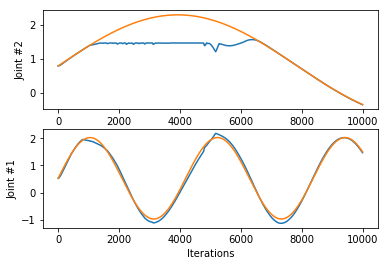

In [27]:
plt.subplot(211)
plt.plot([q[11] for q in hq])
plt.plot([q[11] for q in hqdes])
plt.ylabel('Joint #2')
plt.subplot(212)
plt.plot([q[3] for q in hq])
plt.plot([q[3] for q in hqdes]);
plt.ylabel('Joint #1')
plt.xlabel('Iterations')

In [36]:
    aq = inv(M) @ (tauq - b)
    ### Integrate the acceleration twice instead of this comment
    vq += aq*dt
    q = pin.integrate(robot.model,q,vq*dt)
    hq.append(q.copy())
    hqdes.append(qdes(t).copy())
    if it%20==0: 
        viz.display(q)
        time.sleep(20*dt)

[ 7.81990729e-06 -2.75548150e-05  3.33506213e-04 -3.27240417e-04
 -1.62745723e-05 -2.97047753e-04  3.55236617e-04  4.97224897e-04
 -4.00432658e-05  1.21425530e-04  4.26396129e-04  2.37308808e-04
  6.38128529e-04  6.58740700e-04]
[ 0.          0.40255355  1.1415293  -0.68231992  1.25495279 -0.09433175
  1.72951747 -0.20775524  0.92615233  1.29917147  1.0916899   2.11311056
  2.25172193  2.28275258]
